<a href="https://colab.research.google.com/github/RodolfoViegas/sistema_previsao_acoes/blob/main/apple_pytorch_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Rede Neural LSTM para previsão da Série temporal de preços da empresa Apple

O modelo é contruído com o API Pytorch e os dados são coletados pelo API pandas data reader.

A série possui frequência de 15 minutos

Fonte de códigos: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn

In [ ]:
df = web.DataReader("AAPL", "av-intraday", start="2020-01-01",end="2021-07-02",
                        api_key='BNYLT38LCDB0TBWF',)    

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6842 entries, 2021-06-21 04:01:00 to 2021-07-01 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6842 non-null   float64
 1   high    6842 non-null   float64
 2   low     6842 non-null   float64
 3   close   6842 non-null   float64
 4   volume  6842 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 320.7+ KB


In [ ]:
df.head(20)

,open,high,low,close,volume
2021-06-21 04:01:00,130.77,131.30,130.65,130.97,3215
2021-06-21 04:02:00,130.97,130.97,130.29,130.29,2945
2021-06-21 04:03:00,130.21,130.35,130.21,130.35,1639
2021-06-21 04:04:00,130.21,130.35,130.21,130.35,596
2021-06-21 04:05:00,130.35,130.46,130.35,130.46,2002
2021-06-21 04:06:00,130.45,130.46,130.45,130.46,3074
2021-06-21 04:12:00,130.46,130.50,130.46,130.50,796
2021-06-21 04:13:00,130.50,130.50,130.50,130.50,1046
2021-06-21 04:20:00,130.44,130.46,130.44,130.46,1034
2021-06-21 04:22:00,130.52,130.54,130.52,130.54,721


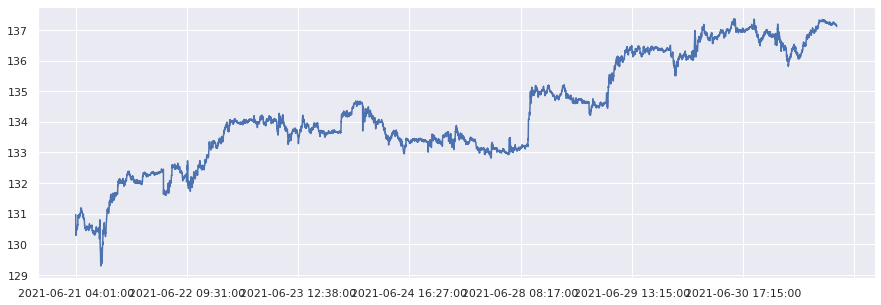

In [ ]:
plt.clf()
df.close.plot(figsize=(15,5))

# Mudança no tipo do índice para 'datetime'

In [ ]:
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6842 entries, 2021-06-21 04:01:00 to 2021-07-01 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6842 non-null   float64
 1   high    6842 non-null   float64
 2   low     6842 non-null   float64
 3   close   6842 non-null   float64
 4   volume  6842 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 320.7 KB


<Figure size 432x288 with 0 Axes>

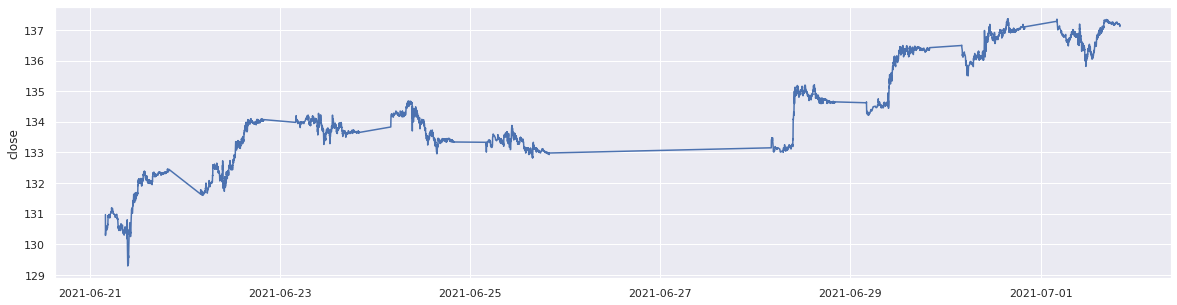

In [ ]:
plt.clf()
line,ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df['close'],ax=ax)

As linhas que ligam pontos são dados em falta, os objetos datetime são criados, porém quando acionados pelo método .head() não parecem na tabela, pois estão vazios de dados. Quando do treino, só valores serão extraídos, podendo-se rejeitar tal formato.


# Estacionariedade

Usando o gráfica acima desse, vemos que aquele possui tendência de declinio nos preços, indicando não-estacionáriedade nos dados. Um modo de verificar a estacionariedade, além de análise no gráfico, são testes estatísticos como Augmented Dickey-Fuller.


In [ ]:
from statsmodels.tsa.stattools import adfuller

X = df.close.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.560342
p-value: 0.503478
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


O p-valor de 0,5 é alto. A a hipóstese nula (H0) é aquela assume que a série é não-estacionária; sendo assim aceitamos H0 e podemos, dadas as evidências, considerar a série temporal como não-estacionária.



Outro modo de averiguarmos se há estacionariedade na série é particionando-a e verificando se a variância e média são iguais na partes.

In [ ]:
part_1 = df.close.iloc[0:int(len(df.close)/2)]
part_2 = df.close.iloc[int(len(df.close)/2):]

In [ ]:
print('Média da 1ª partição: ',part_1.mean(),'Média da 2ª partição: ',part_2.mean())

Média da 1ª partição:  133.0704536977493 Média da 2ª partição:  135.5557632271263


In [ ]:
print('Variância da 1ª partição: ',part_1.var(),'Variância da 2ª partição: ',part_2.var())

Variância da 1ª partição:  1.1970966439022401 Variância da 2ª partição:  1.9434596300333284


Os valores são diferentes dando mais evidências.

Há formas de minimizar a estacionariedade, como diferenciação e transformação logarítmica, ambas bastante usadas para os modelos ARIMA. 

Neste trabalho utilizaremos a transformação logarítimica para suavizar as diferenças.

# Mudança de Frequência nos dados 

A original é por minutos, passaremos para 15 minutos.

In [ ]:
df = df.asfreq('15Min',)
df = df[df.index.dayofweek < 5].copy()
df

,open,high,low,close,volume
2021-06-21 04:01:00,130.77,131.3000,130.65,130.9700,3215.0
2021-06-21 04:16:00,NaN,NaN,NaN,NaN,NaN
2021-06-21 04:31:00,NaN,NaN,NaN,NaN,NaN
2021-06-21 04:46:00,NaN,NaN,NaN,NaN,NaN
2021-06-21 05:01:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-07-01 18:46:00,137.20,137.2001,137.20,137.2001,353.0
2021-07-01 19:01:00,137.21,137.2100,137.21,137.2100,153.0
2021-07-01 19:16:00,NaN,NaN,NaN,NaN,NaN
2021-07-01 19:31:00,137.18,137.1800,137.18,137.1800,470.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 832 entries, 2021-06-21 04:01:00 to 2021-07-01 19:46:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    466 non-null    float64
 1   high    466 non-null    float64
 2   low     466 non-null    float64
 3   close   466 non-null    float64
 4   volume  466 non-null    float64
dtypes: float64(5)
memory usage: 39.0 KB


# Separação em conjuntos de treino e teste e Pré-processamento

In [ ]:
train = df['close'].iloc[0:len(df['close'])-int(len(df['close'])*0.2)]
test = df['close'].iloc[len(df['close'])-int(len(df['close'])*0.2):]
print(len(train),len(test))

666 166


Após a mudança de frequência muitos dados acabam ficando em falta, para corrigir usamos a interpolação linear e preenchimento com o valor mais próximo.

In [ ]:
train.isna().sum()

304

In [ ]:
test.isna().sum()

62

In [ ]:
train = train.interpolate()
test = test.interpolate()

In [ ]:
print(train.isna().sum(),test.isna().sum())

0 6


In [ ]:
test.fillna(inplace=True,method='bfill')

In [ ]:
print(train.isna().sum(),test.isna().sum())

0 0


<Figure size 432x288 with 0 Axes>

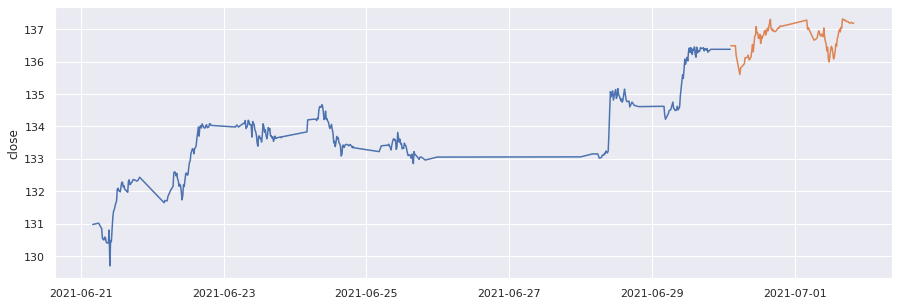

In [ ]:
plt.clf()
line,ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=train,ax=ax)
sns.lineplot(data=test,ax=ax)

O gráfico é semelhante ao original, sendo menos ruidoso.

In [ ]:
# Transformação logarítimica, normalização (-1,1) e "lagging" (5).

In [ ]:
log_train = np.log(train)
log_test = np.log(test)

In [ ]:
# Valores normalizados. Quando a escala é adequada a um intervalo, no caso -1, 1 para este trabalho, a rede
# neural consegue trabalhar melhor.


log_train = np.array(log_train).reshape(log_train.shape[0],1)
log_test = np.array(log_test).reshape(log_test.shape[0],1)

scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(log_train.reshape(log_train.shape[0],1))

log_train_normalized = scaler.transform(log_train)
log_test_normalized = scaler.transform(log_test)



In [ ]:
# Transformação dos tensores numpy em  objetos Tensores de pytorch

log_train_normalized = torch.FloatTensor(log_train_normalized).view(-1)
log_test_normalized = torch.FloatTensor(log_test_normalized).view(-1)


In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
# criação dos conjutos com "lags" de 5

train = create_inout_sequences(log_train_normalized, 5)
test = create_inout_sequences(log_test_normalized, 5)

In [ ]:
torch.manual_seed(0)

In [ ]:
class ModeloLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        """É possível fazer um 'stack' de camadas como nas outras redes pytorch. O modo pytorch mais usado para LSTM, é passado ao 
        parâmetro 'num_layer' um valor equivalente a quantidade de camadas; só que usando esse jeito não
        é possível controlar a quantidade de células de memória nas camadas internal,o número de neurônios será o mesmo valor para todas.
        Fazendo uma pilha de camadas semelhante a arquiteturas como o MLP e Convolucional, é preciso tomar cuidado no valor do parâmetro 'input_size'
        , que o número de 'features' de um vetor (no caso se séries temporais é um vetor simples de dimensão 1). Esse valor será
        sempre o mesmo para o parâmetro em todas as layers, ou seja, se a quantidade de features é 1,o input_size será sempre 1.
        
        A camada MLP (Linear) possui o tamanho da entrada 'in_features' igual ao hidden state da LSTM anterior. """

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=70,num_layers=1)

        self.lstm2 = nn.LSTM(input_size=1, hidden_size=50,num_layers=1)

        self.linear = nn.Linear(in_features=50, out_features=1)
        
        #Este dois atributos representam os hidden state e cell state para cada uma das camadas

        # hidden state e cell state da 1 camada
        self.hidden_cell_1 = (torch.zeros(1,1,70),
                              torch.zeros(1,1,70))
        
        # hidden state e cell state da 2  camada
        self.hidden_cell_2 = (torch.zeros(1,1,50),
                              torch.zeros(1,1,50)) 

    def forward(self, input_seq):
        lstm_out_1, _ = self.lstm1(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell_1)

        lstm_out_2, _ = self.lstm2(input_seq.view(len(lstm_out_1) ,1, -1), self.hidden_cell_2)
        predictions = self.linear(lstm_out_2.view(len(input_seq), -1))
        return predictions[-1]
      

In [ ]:
model = ModeloLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
print(model)

ModeloLSTM(
  (lstm1): LSTM(1, 70)
  (lstm2): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
epochs = 5
for i in range(epochs):
    for seq, labels in train:
        optimizer.zero_grad()
        model.hidden_cell_1 = (torch.zeros(1, 1, 70),
                        torch.zeros(1, 1, 70))
        
        model.hidden_cell_2 = (torch.zeros(1, 1, 50),
                        torch.zeros(1, 1, 50))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00088340
epoch:   4 loss: 0.0000008170


#Fase de teste

As métricas escolhidas foram RMSE e MAE

In [ ]:
model.eval
preds = []
labels = []
for seq, label in test:
    y_pred= model(seq)
    preds.append(y_pred)
    labels.append(label)
    



# RMSE e MAE
print(np.sqrt(mean_squared_error(preds, labels)))
print(mean_absolute_error(preds, labels))
        

0.0615674586857886
0.05369377469424135


In [ ]:
np_preds = []
for i in preds:
    np_preds.append(i.detach().numpy())
np_preds = np.array(np_preds).reshape((161,1))

# Gráfico plotando os valores preditos e reais.

<Figure size 432x288 with 0 Axes>

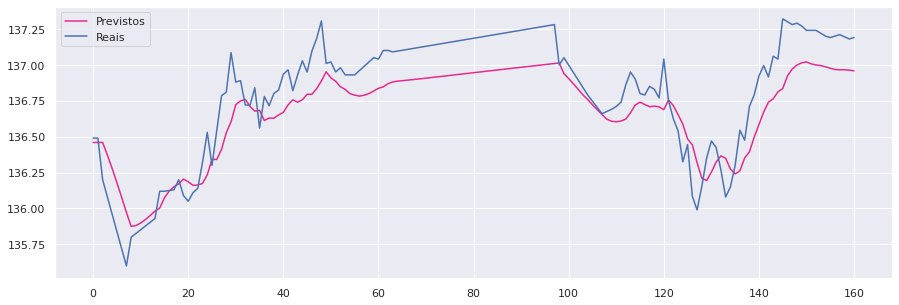

In [ ]:
plt.clf()
line,ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=np.exp(scaler.inverse_transform(np_preds)),ax=ax, palette='Dark2_r',legend='' )
sns.lineplot(data=np.exp(scaler.inverse_transform(np.array(labels).reshape(161,1))),ax=ax,)
plt.legend(labels=['Previstos','Reais'])

In [ ]:
# A biblioteca recomenda salva o modelo desta forma

torch.save(model.state_dict(), 'model_final_dict_torch_lstm_apple.pth')

In [ ]:
# carregar novamente o modelo é preciso instânciá-lo e caso esse seja levado ao outro ambiente lembrar de salva
# a forma da classe criada para o carregamento correto.
model = ModeloLSTM()
model.load_state_dict(torch.load('model_final_dict_torch_lstm_apple.pth'))
model.eval()

ModeloLSTM(
  (lstm1): LSTM(1, 70)
  (lstm2): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# Para a reutilização do modelo em produção a escala que os dados foram normalizados também deve ser salva
# após salva-lo, para o carregar faço como abertura de arquivo, fechando-o ao fim
from pickle import dump

dump(scaler, open('scaler.pkl', 'wb'))